In [19]:
import os
from matplotlib import test
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
batch_size=64

train='ORAL_CANCER/train'
test='ORAL_CANCER/test'
val='ORAL_CANCER/val'

train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
validation_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

test_datagen= image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_generator = train_datagen.flow_from_directory(
    train,
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'binary')

validation_generator = validation_datagen.flow_from_directory(
    val,
    target_size = (224,224),
    batch_size =batch_size,
    shuffle=True,
    class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(
    test,
    target_size = (224,224),
    batch_size =batch_size,
    class_mode = 'binary')
class_names=list(test_generator.class_indices.keys())
class_names

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


['Normal', 'OSCC']

In [20]:
base_for_model = resnet.ResNet101(weights='imagenet', include_top=False,input_shape=(224,224,3))
for layer in base_for_model.layers:
    layer.trainable = False

In [29]:
model = Sequential()
model.add(base_for_model) 
model.add(GaussianNoise(0.25)) #to prevent overfitting
model.add(GlobalMaxPooling2D()) #to converge and reduce the parameters
model.add(Dense(512, activation = 'relu')) #hidden layer (relu activation function is suggested for images)
model.add(BatchNormalization()) #to prevent overfitting
model.add(Dense(1, activation='sigmoid')) #output layer
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 gaussian_noise_3 (GaussianN  (None, 7, 7, 2048)       0         
 oise)                                                           
                                                                 
 global_max_pooling2d_3 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                      

In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC']
)
mp= tf.keras.callbacks.ModelCheckpoint(filepath='models/mymodel.h5', verbose=2, save_best_only=True)
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.05, patience=3)
callback=[es,mp]

In [31]:
history=model.fit(
    train_generator,
    epochs=5,
    batch_size=batch_size,
    callbacks=callback,
    validation_data=test_generator
)

Epoch 1/5
78/78 [==============================] - ETA: 0s - loss: 0.5303 - accuracy: 0.7531 - precision: 0.7639 - recall: 0.7435 - auc: 0.8378
Epoch 1: val_loss improved from inf to 2.13951, saving model to models\mymodel.h5
78/78 [==============================] - 192s 2s/step - loss: 0.5303 - accuracy: 0.7531 - precision: 0.7639 - recall: 0.7435 - auc: 0.8378 - val_loss: 2.1395 - val_accuracy: 0.4524 - val_precision: 1.0000 - val_recall: 0.2737 - val_auc: 0.8462
Epoch 2/5
78/78 [==============================] - ETA: 0s - loss: 0.3719 - accuracy: 0.8275 - precision: 0.8367 - recall: 0.8204 - auc: 0.9130
Epoch 2: val_loss improved from 2.13951 to 0.77607, saving model to models\mymodel.h5
78/78 [==============================] - 156s 2s/step - loss: 0.3719 - accuracy: 0.8275 - precision: 0.8367 - recall: 0.8204 - auc: 0.9130 - val_loss: 0.7761 - val_accuracy: 0.6905 - val_precision: 1.0000 - val_recall: 0.5895 - val_auc: 0.8849
Epoch 3/5
78/78 [==============================] - ETA: 

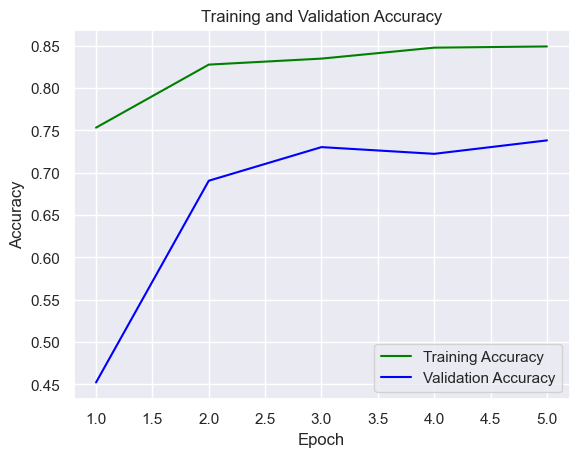

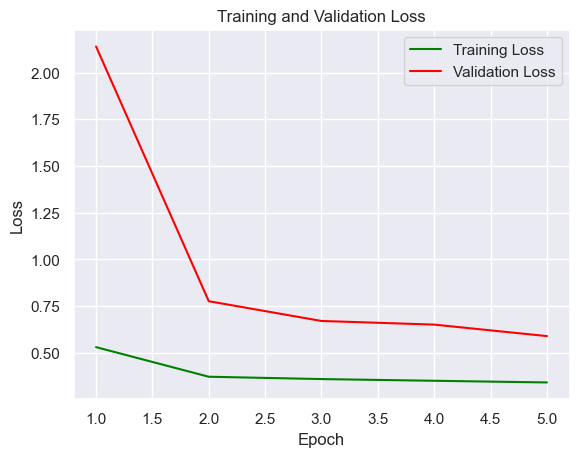

In [32]:
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


2/2 [==============================] - 12s 5s/step


<AxesSubplot:>

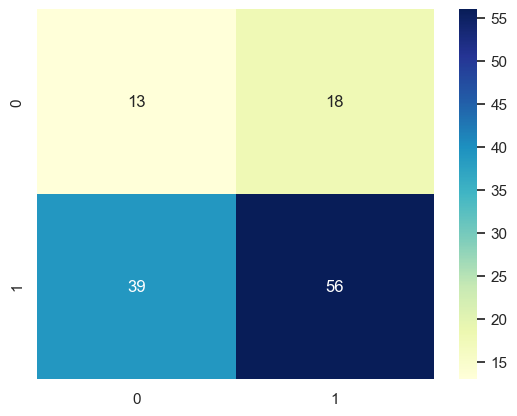

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_generator)
cm = confusion_matrix(test_generator.classes, predictions.round())

sns.heatmap(cm,  annot=True, fmt="d" ,cmap="YlGnBu")

In [34]:
score=model.evaluate(validation_generator)

2/2 [==============================] - 12s 5s/step - loss: 0.6585 - accuracy: 0.7000 - precision: 0.9118 - recall: 0.6739 - auc: 0.8377


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, predictions.round())) 

In [66]:
import cv2
image=plt.imread('ORAL_CANCER/train/OSCC/OSCC_100x_13.jpg')
imge=cv2.resize(image,(224,224))
im=np.true_divide(imge,255)
img=np.expand_dims(imge,axis=0)
z=model.predict(img)
#plt.imshow(image)
#s=z.round().astype("int")
#s
z=np.round(z)
if z==0:
    print("Normal")
else:
    print("OSCC")
z

1/1 [==============================] - 0s 31ms/step
OSCC


array([[1.]], dtype=float32)

In [57]:
model.save('models/oral.h5')

In [63]:
models=load_model('models/oral.h5')

1/1 [==============================] - 0s 30ms/step
OSCC


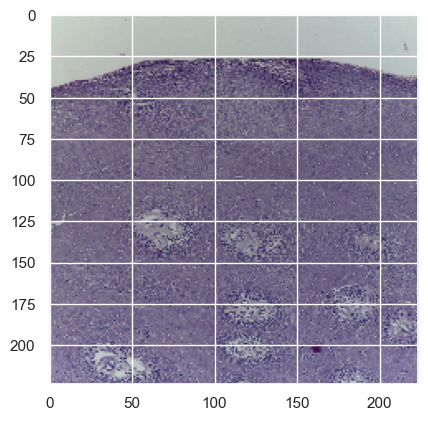

In [73]:
image=plt.imread('ORAL_CANCER/train/OSCC/OSCC_100x_13.jpg')
imge=cv2.resize(image,(224,224))
im=np.true_divide(imge,255)
img=np.expand_dims(imge,axis=0)
z=models.predict(img)
z=np.round(z)
if z==0:
    print("Normal")
else:
    print("OSCC")

z
plt.imshow(imge)